# Cart Pole Experimentation

Cart Pole is an environment provided by OpenAI gym. This is a really basic Reinforcement Learning (RL) environment - I recently saw it described as the "Hello World" of RL. The environment considers a pole on a cart, and the cart can either move left or right in order to keep the pole upright. If the pole falls beyond a certain angle, or the cart moves outside certain bounds, the episode terminates. 

The state is defined by the observation - this has cart position, cart velocity, pole angle, and pole
angular velocity in that order (these numbers are the output from env.reset()). env.step(action = 0 or 1) gives us observation, reward, done, info, in that order. The reward is +1 for every additional step, including the termination step. More information on the environment can be found here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

In this notebook, I want to build and train a RL agent to solve this environment successfully using a DDQN algorithm. I plan on experimenting with the following variables:
- Neural net architectures
- Learning rates 
- Epsilon values

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import gymnasium as gym
from IPython import display
plt.rcParams['figure.dpi'] = 150

### Agent Class

In [9]:
class DQNAgent():
    """
    RL agent that utilizes a DQN algorithm to solve the Cart Pole environment.
    """
    
    def __init__(self, gamma=0.95, epsilon=0.9, epsilon_decay=0.99, epsilon_min=0.04, tau=0.99):
        """
        Initialize agent.
        
        Arguments:
            gamma (float): Future reward discounting factor
            epsilon (float): Starting value representing percentage of the time that the agent chooses a random action. E.g 0.75 = 75%
            epsilon_decay (float): Epsilon is multiplied by this factor after each episode.
            epsilon_min (float): Minimum value for epsilon.
            tau (float): Rate at which the target-q network is updated.
            
        Returns:
            None
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min 
        self.tau = tau
        self.q_function = self.make_q_function()
        self.q_function.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-4)) 
        self.target_q = self.make_q_function()
        self.target_q.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-4))
        self.target_q.set_weights(self.q_function.weights)
        self.max_memory = 10000
    
    
    def find_action(self, state):
        """
        Taking an action according to current policy of the agent. 
        
        Arguments:
            state (ndarray): cart position, cart velocity, pole angle, and pole angular velocity
        
        Returns:
            action (int): 0 or 1, corresponding to whether to push the cart left or right.
        """
        
        # If the random number is less than epsilon, we choose the action randomly
        if np.random.random() < self.epsilon:
            action = np.random.randint(0, 2)
            
        # Otherwise, choose the action that is the agent's current best guess for max future reward
        else:
            # Find action with best q-value
            # Find q-value estimates for each action using q-function
            q_vals = self.q_function.predict(state[np.newaxis, :], verbose=False)
            # Find best value by taking index of the largest argument
            action = np.argmax(q_vals)
    
        return action
    
    
    def take_step(self, env):
        """
        Take a step in the Cart Pole environment with the agent.
        
        Arguments:
            env: Cart Pole environment object
        
        Returns:
            old_state (ndarray): initial cart position, cart velocity, pole angle, and pole angular velocity
            action (int): 0 or 1, corresponding to whether the cart was pushed left or right
            reward (int): +1 if the episode has not yet terminated, 0 otherwise
            new_state (ndarray): new cart position, cart velocity, pole angle, and pole angular velocity
            done (bool): Whether or not episode has terminated
        """
        
        # Find action
        action = self.find_action(self.state)
        
        # Take step
        new_state, reward, done, info = env.step(action)[:4]
        old_state = self.state
        self.state = new_state
        
        return old_state, action, reward, new_state, done
    
    
    def make_q_function(self):
        """
        Create a q-function to estimate optimal total reward values for a given state-action pair.
        
        Arguments:
            None
        
        Returns:
            model: Untrained Keras sequential model. 
        """
        
        # Keras Sequential model
        # 2 outputs corresponding to left and right actions
        model = Sequential(
            [
                Dense(128, activation='relu', input_shape=(4,)),
                Dense(64, activation='relu'),
                Dense(64, activation='relu'),
                Dense(2, activation='linear')
            ]
        )
        
        return model
        
    
    def train(self):
        """
        Use memory of experience to train agent using gradient descent.
        
        Arguments:
            None
            
        Returns:
            None
        """
            
        # Define target = current reward + gamma * target q of next state
        
        # Target q network predictions of future reward
        future_reward = np.max(self.target_q.predict(self.memory[:, -4:], verbose=False), axis=1)
        # Accounting for steps where episode terminated (no future reward)
        future_reward = np.where(self.memory[:, 6], 0, future_reward)
        
        target_vals = self.memory[:, 5] + self.gamma * future_reward
        
        # Creating targets
        q_vals = self.q_function.predict(self.memory[:, :4], verbose=False)
        
        current_actions = self.memory[:, 4]
        # Replacing q_function predictions with target_q targets
        col1 = ((q_vals[:, 0] * current_actions) + ((1 - current_actions) * target_vals)).reshape(q_vals.shape[0], 1)
        col2 = ((q_vals[:, 1] * (1 - current_actions)) + (current_actions * target_vals)).reshape(q_vals.shape[0], 1)
        final_target = np.concatenate((col1, col2), axis=1)
        
        # Train q-function with mse against target-q
        self.q_function.fit(self.memory[:, :4], final_target, shuffle=True, batch_size=64, verbose=False)
        
        # Using Polyak averaging to soft update target-q to be tau * target q weights + (1 - tau) * q weights
        new_weights = [self.tau * i + (1 - self.tau) * j for i, j in zip(self.target_q.weights, self.q_function.weights)]
        self.target_q.set_weights(new_weights) 
        
        
    def go(self, env, num_rounds=100):
        """
        Run the agent till termination num_rounds times.
        
        Arguments:
            env: Cart Pole environment object
            num_rounds (int): Number of times we want the agent to run until termination.
            
        Returns:
            None
        """
        
        # Initializing memory and episode length record
        self.memory = np.zeros((1, 11))
        length_lst = []
        
        # Each round is a complete runthrough of the environment until termination
        for i in tqdm(range(num_rounds)):
            
            # Tracking whether or not current iteration has terminated
            complete = False
            
            # Resetting to initial state
            self.state = env.reset()[0]
            
            # Variable to keep track of number of steps taken in each round
            length = 0
            
            while not complete:
                
                # Continue taking steps until termination
                old_state, action, reward, new_state, done = self.take_step(env)
                
                # Add data to agent memory
                if self.memory.any():
                    curr_data = np.append(np.append(old_state, (action, reward, done)), new_state).reshape(1, 11)
                    self.memory = np.concatenate((self.memory, curr_data), axis=0)
                else: 
                    self.memory = (np.append(np.append(old_state, (action, reward, done)), new_state)).reshape(1, 11)
                
                # Need > 64 for batch size
                if len(self.memory) > 64:
                    self.train()
                
                if done:
                    complete = True
                    
                length += 1
                
                if length > 550:
                    break

            # Sample memory if exceeding memory limit
            # Always keep initial 1000 steps' data
            if len(self.memory) > self.max_memory:
                idx = np.random.randint(1000, len(self.memory), size=self.max_memory - 1000) 
                self.memory = self.memory[np.append(np.arange(1000), idx), :]
                
             # Decrease epsilon
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon, self.epsilon_min)
            
            length_lst.append(length)
            
            if np.mean(length_lst[-10:]) >= 475:
                break
            
            if i % 10 == 0:
                print("Episode {}: \nlast 10 reward avg: {} \nepsilon: {} \nMemory size: {}".format(i, np.mean(length_lst[-10:]), self.epsilon, self.memory.shape[0]))
                               
        return length_lst


### Function for performance evaluation

In [10]:
def rolling_average(lengths, window):
    """
    Find the rolling average of the episode length.
    
    Arguments:
        lengths (lst): List of episode lengths
        window (int): Length of rolling average window of consideration
        
    Returns:
        avgs (lst):
    """
    avgs = []
    for i in range(len(lengths)):
        if i < window:
            avgs.append(0)
        else:
            avgs.append(np.mean(lengths[i - window: i]))
    return avgs

### Building and evaluating agent

In [11]:
agent = DQNAgent()

In [12]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [ ]:
lengths = agent.go(env, num_rounds=300)

  0%|▎                                                                                            | 1/300 [00:00<00:29,  9.98it/s]

Episode 0: 
last 10 reward avg: 11.0 
epsilon: 0.891 
Memory size: 11


  4%|███▎                                                                                        | 11/300 [00:07<04:20,  1.11it/s]

Episode 10: 
last 10 reward avg: 15.6 
epsilon: 0.8058044288328449 
Memory size: 167


  7%|██████▍                                                                                     | 21/300 [00:22<08:05,  1.74s/it]

Episode 20: 
last 10 reward avg: 20.1 
epsilon: 0.7287550813991327 
Memory size: 368


 10%|█████████▌                                                                                  | 31/300 [00:51<16:21,  3.65s/it]

Episode 30: 
last 10 reward avg: 30.5 
epsilon: 0.6590730326889578 
Memory size: 673


 14%|████████████▌                                                                               | 41/300 [01:42<23:00,  5.33s/it]

Episode 40: 
last 10 reward avg: 49.8 
epsilon: 0.5960538368855853 
Memory size: 1171


 17%|███████████████▋                                                                            | 51/300 [02:10<12:33,  3.02s/it]

Episode 50: 
last 10 reward avg: 24.7 
epsilon: 0.5390604058195451 
Memory size: 1418


 20%|██████████████████▋                                                                         | 61/300 [02:44<12:33,  3.15s/it]

Episode 60: 
last 10 reward avg: 26.7 
epsilon: 0.48751656837016827 
Memory size: 1685


 24%|█████████████████████▊                                                                      | 71/300 [03:39<19:42,  5.17s/it]

Episode 70: 
last 10 reward avg: 40.8 
epsilon: 0.4409012457037845 
Memory size: 2093


 27%|████████████████████████▊                                                                   | 81/300 [04:51<23:02,  6.31s/it]

Episode 80: 
last 10 reward avg: 48.4 
epsilon: 0.39874318346355536 
Memory size: 2577


 30%|███████████████████████████▉                                                                | 91/300 [06:44<47:51, 13.74s/it]

Episode 90: 
last 10 reward avg: 67.4 
epsilon: 0.3606161876563865 
Memory size: 3251


 34%|██████████████████████████████▋                                                            | 101/300 [07:54<37:33, 11.33s/it]

Episode 100: 
last 10 reward avg: 37.8 
epsilon: 0.3261348160744472 
Memory size: 3629


 37%|█████████████████████████████████▋                                                         | 111/300 [09:01<28:32,  9.06s/it]

Episode 110: 
last 10 reward avg: 33.3 
epsilon: 0.2949504816940234 
Memory size: 3962


 40%|████████████████████████████████████▋                                                      | 121/300 [10:58<30:29, 10.22s/it]

Episode 120: 
last 10 reward avg: 55.3 
epsilon: 0.26674792865928726 
Memory size: 4515


 44%|███████████████████████████████████████▋                                                   | 131/300 [13:39<45:15, 16.07s/it]

Episode 130: 
last 10 reward avg: 70.2 
epsilon: 0.24124204522518672 
Memory size: 5217


 47%|██████████████████████████████████████████▊                                                | 141/300 [17:33<48:46, 18.41s/it]

Episode 140: 
last 10 reward avg: 94.2 
epsilon: 0.2181749814401222 
Memory size: 6159


 50%|█████████████████████████████████████████████▊                                             | 151/300 [20:42<50:51, 20.48s/it]

Episode 150: 
last 10 reward avg: 67.7 
epsilon: 0.1973135424298251 
Memory size: 6836


 51%|██████████████████████████████████████████████▋                                            | 154/300 [21:21<39:06, 16.07s/it]

Text(0, 0.5, 'Episode length')

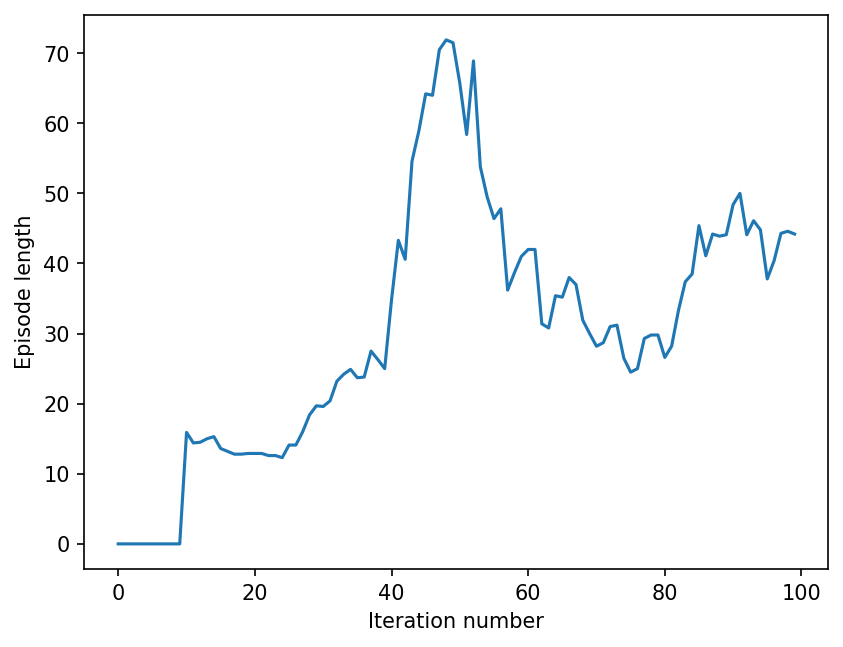

In [17]:
iters = np.arange(100)
plt.plot(iters, rolling_average(lengths, 10))
plt.xlabel("Iteration number")
plt.ylabel("Episode length")

In [ ]:
done = False

env = gym.make('CartPole-v1', render_mode='rgb_array')
agent.state = env.reset()[0]
agent_lengths = []

for i in tqdm(range(100)):
    
    env.reset()
    
    ep_length = 0
    
    done = False
    
    while not done:
        _, _, _, _, done = agent.take_step(env)
        ep_length += 1
    
    agent_lengths.append(ep_length)

In [ ]:
done = False

env = gym.make('CartPole-v1', render_mode='rgb_array')
random_lengths = []

for i in tqdm(range(100)):
    
    env.reset()
    
    done = False
    
    ep_length = 0
    
    while not done:
        action = np.random.randint(0, 2)
        _, _, done, _, _ = env.step(action)
        ep_length += 1
    
    random_lengths.append(ep_length)

In [ ]:
np.mean(agent_lengths)

In [ ]:
np.mean(random_lengths)

In [ ]:
plt.plot(np.arange(100), rolling_average(agent_lengths, 10), label='Agent')
plt.plot(np.arange(100), rolling_average(random_lengths, 10 ), label='Random')
plt.legend()

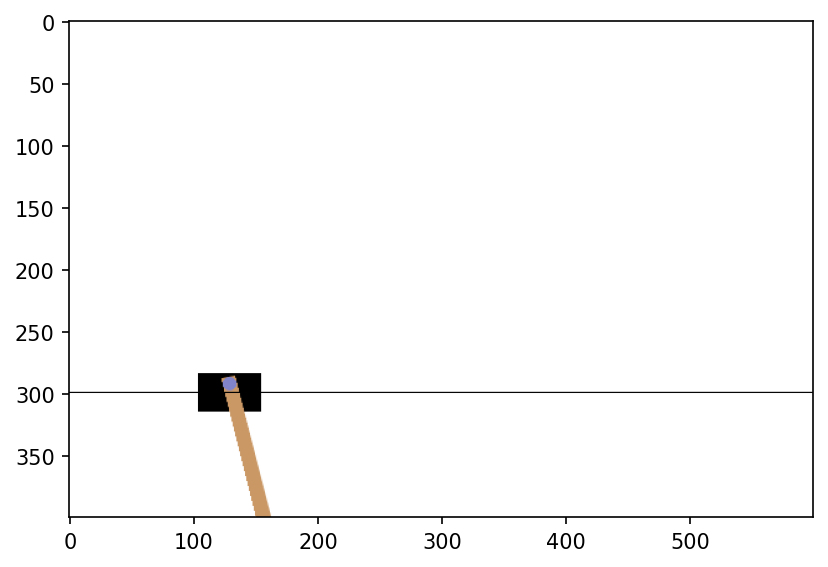

In [50]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
agent.state = env.reset()[0]

for i in range(50):
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)
#     env.step(env.action_space.sample()) # take a random action
    env.step(agent.find_action(agent.state))
    agent.state = np.array(env.state)
    
env.close()